# Usage Demo : 


In [1]:
import midi
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

## Absolute measurement: statistic analysis


Assign dataset path

In [8]:
set1 = glob.glob('../streams_to_midi/*.mid')

construct empty dictionary to fill in measurement across samples

In [9]:
num_samples = 100

In [10]:
set1_eval = {'total_used_pitch':np.zeros((num_samples,1))}
metrics_list = list(set1_eval.keys())
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    set1_eval[metrics_list[0]][i] = getattr(core.metrics(), metrics_list[0])(feature)

repeat for second dataset

In [5]:
set2 = glob.glob('../stats/*.mid')
set2_eval = {'total_used_pitch':np.zeros((num_samples,1))}
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    set2_eval[list(metrics_list)[0]][i] = getattr(core.metrics(), list(metrics_list)[0])(feature)

In [6]:
len(set2)

100

statistic analysis: absolute measurement

In [11]:
for i in range(0, len(metrics_list)):
    print (metrics_list[i] + ':')
    print ('------------------------')
    print (' demo_set')
    print ('  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0))
    print ('  std: ', np.std(set1_eval[metrics_list[i]], axis=0))

    print ('------------------------')
    print (' demo_set')
    print ('  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0))
    print ('  std: ', np.std(set2_eval[metrics_list[i]], axis=0))


total_used_pitch:
------------------------
 demo_set
  mean:  [7.62]
  std:  [1.36952547]
------------------------
 demo_set
  mean:  [8.45]
  std:  [1.94100489]


## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [12]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])


exhaustive cross-validation for inter-set distances measurement

In [13]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

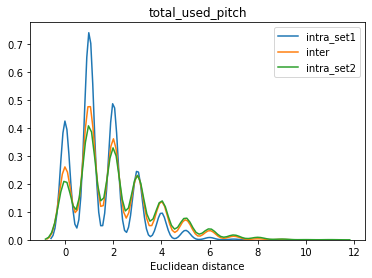

In [14]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

the difference of intra-set and inter-set distances.

In [16]:
for i in range(0, len(metrics_list)):
    print (metrics_list[i] + ':')
    print ('------------------------')
    print (' demo_set1')
    print ('  Kullback–Leibler divergence:',utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i]))
    print ('  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i]))
    
    print (' demo_set2')
    print ('  Kullback–Leibler divergence:',utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i]))
    print ('  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i]))
    

total_used_pitch:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.38672610074110036


C:\scripts\mgeval-master\mgeval\utils.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


  Overlap area: 0.7464689140623747
 demo_set2
  Kullback–Leibler divergence: 0.18164751080662414
  Overlap area: 0.86837210388408
